# Prediction and Analysis of Coronavirus (COVID19) | Priya Bannur PB 23

### Tasks covered:
1. Handling missing data
2. Label Encoding
3. K-Means Clustering

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import random
from sklearn import preprocessing
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder

## Loading the dataset

In [2]:
def load_data():
    df = pd.read_csv('SK_patient.csv')
    df['released_date'] = pd.to_datetime(df['released_date'])
    df['confirmed_date'] = pd.to_datetime(df['confirmed_date'])
    df['month'] = df['confirmed_date'].dt.month
    df['day'] = df['confirmed_date'].dt.day
    return df

In [3]:
df_south_korea = load_data()
df_south_korea.isnull().sum()

patient_id               0
global_num            1089
sex                     66
birth_year             437
age                     74
country                  0
province                 0
city                    79
disease               3308
infection_case         767
infection_order       3295
infected_by           2520
contact_number        2712
symptom_onset_date    2855
confirmed_date           3
released_date         2108
deceased_date         3266
state                    0
month                    3
day                      3
dtype: int64

In [4]:
df_south_korea.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,month,day
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,1.0,23.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released,1.0,30.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,1.0,30.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,1.0,30.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,1.0,31.0


In [5]:
# dropping unimportant columns

df_south_korea.drop(['province','disease','patient_id','infected_by','infection_case','symptom_onset_date','deceased_date','released_date'], axis=1, inplace=True)

## Handling missing values

In [6]:
print(df_south_korea.isnull().sum())

global_num         1089
sex                  66
birth_year          437
age                  74
country               0
city                 79
infection_order    3295
contact_number     2712
confirmed_date        3
state                 0
month                 3
day                   3
dtype: int64


## 1. Age

In [7]:
#creating a function to simulate population's age based on available data

def simulate_age(ranges, percents, total_pop):
    simulated_pop = np.array(0)
    for (low, high), percent in zip(ranges, percents):
        simulated_pop = np.append(simulated_pop, 
                  np.random.randint(low=low, high=high, size=int(total_pop*percent/100)))
    return simulated_pop

In [8]:
# data from the internet

'''
0-14 years: 13.03% 
15-24 years: 12.19%
25-54 years: 45.13%
55-64 years: 15.09% 
65 years and over: 14.55% 
'''
ranges = [(0,14),(15,24),(25,54),(55,64),(65,90)]
south_korea_population = 51418097
percents = [13.03,12.19,45.13,15.09,14.55]
south_korea_simulated_pop = simulate_age(ranges, percents, south_korea_population)

In [9]:
actual_year = pd.to_datetime('today').year
def calculate_age(x):
    if math.isnan(x):
        return x
    else:
        return int(actual_year - x)
    
#populations
south_korea_population = 51418097
    
#France
df_south_korea['age'] = df_south_korea['birth_year'].apply(calculate_age)

df_south_korea.fillna({'age':int(random.choice(south_korea_simulated_pop))}, inplace=True)

df_south_korea.drop(['birth_year'], axis=1, inplace=True)

## 2. Sex

In [10]:
'''
Considering m as men and w as women. 
m/w=ratio -> m=ration*w
m+w=total_pop
'''
def calculate_values(ratio, total_pop):
    w = (south_korea_population/(1+ratio))/total_pop
    m = 1 - w
    return (w,m)

In [11]:
# South Korea
# total population: 1 male(s)/female (2018 est.)
w,m = calculate_values(1, south_korea_population)

df_south_korea['sex'] = df_south_korea['sex'].str.lower()

df_south_korea['sex'].replace({"male\xa0?": "male"}, inplace=True)

df_south_korea.fillna({'sex': np.random.choice(['female','male'],p=[w,m])}, inplace=True)

In [12]:
df_south_korea.fillna({'infection_reason':'Unknown','group':'Unknown',
                       'infection_order':0, 'contact_number':0, 'state':'Unknown'} , inplace=True)

In [13]:
#checking again
print(df_south_korea.isnull().sum())
df=df_south_korea.dropna()
print(df.isnull().sum())

global_num         1089
sex                   0
age                   0
country               0
city                 79
infection_order       0
contact_number        0
confirmed_date        3
state                 0
month                 3
day                   3
dtype: int64
global_num         0
sex                0
age                0
country            0
city               0
infection_order    0
contact_number     0
confirmed_date     0
state              0
month              0
day                0
dtype: int64


## Label Encoding Sex attribute

In [14]:
le=LabelEncoder()
df['sex']=le.fit_transform(df['sex'])
df.head()
#Male=1, Female=0

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,global_num,sex,age,country,city,infection_order,contact_number,confirmed_date,state,month,day
0,2.0,1,56.0,Korea,Gangseo-gu,1.0,75.0,2020-01-23,released,1.0,23.0
1,5.0,1,33.0,Korea,Jungnang-gu,1.0,31.0,2020-01-30,released,1.0,30.0
2,6.0,1,56.0,Korea,Jongno-gu,2.0,17.0,2020-01-30,released,1.0,30.0
3,7.0,1,29.0,Korea,Mapo-gu,1.0,9.0,2020-01-30,released,1.0,30.0
4,9.0,0,28.0,Korea,Seongbuk-gu,2.0,2.0,2020-01-31,released,1.0,31.0


In [15]:
pca_df = df[['sex', 'age', 'infection_order']].copy()

# KMeans Clustering 

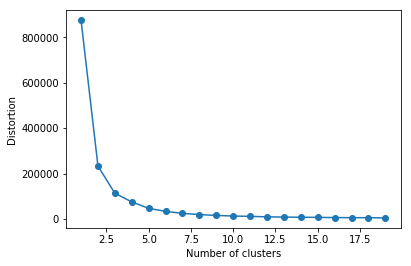

The optimal number of clusters is 3


In [16]:
# Using the elbow test to check optimal number of components

def elbow_test(df, n_init, max_clusters, max_iter):
    distortions = []
    for i in range(1, max_clusters):
        km = KMeans(
            n_clusters=i, init='random',
            n_init=n_init, max_iter=max_iter,
            tol=1e-04, random_state=20
        )
        km.fit(df)
        distortions.append(km.inertia_)
    plt.plot(range(1, max_clusters), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()
    
    kn = KneeLocator(
            range(1, max_clusters),
            distortions,
            curve='convex',
            direction='decreasing',
            interp_method='interp1d',
    )
    return kn.knee

n_clusters = elbow_test(pca_df, 10, 20, 300)
print(f'The optimal number of clusters is {n_clusters}')

In [17]:
# Running KMeans Algo

km = KMeans(n_clusters=n_clusters, random_state=20)

y = km.fit_predict(pca_df)
idx = np.argsort(km.cluster_centers_.sum(axis=1))

lut = np.zeros_like(idx)
lut[idx] = np.arange(n_clusters)

pca_df['cluster'] = lut[km.labels_]
df['cluster'] = lut[km.labels_]

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [18]:
#Saving data

import pickle   
pickle.dump(km, open('kmeans_model.sav', 'wb'))
# Load
km = pickle.load(open('kmeans_model.sav', 'rb'))

In [19]:
def draw_scatter(df, col_1, col_2, cluster_column, num_clusters, title):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(col_1)
    ax.set_ylabel(col_2)
    labels = list(range(0,num_clusters))
    colors = plt.cm.Spectral(np.linspace(0, 1, num_clusters))
    axs = []
    for i in labels:
        axs.append(ax.scatter(df[df[cluster_column]==i][col_1], df[df[cluster_column]==i][col_2], cmap=colors[i]))
        ax.legend(axs, labels, loc='center', bbox_to_anchor=(0.92, 0.84), ncol=1)
    plt.show()

<Figure size 1440x720 with 0 Axes>

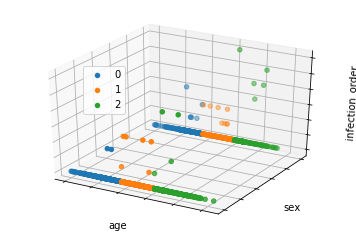

In [20]:
# function for 3d

def create_3d_scatter(df, col_1, col_2, col_3, cluster_column, num_clusters, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title)
    ax.set_xlabel(col_1)
    ax.set_ylabel(col_2)
    ax.set_zlabel(col_3, rotation=90)
    labels = list(range(0,num_clusters))
    colors = plt.cm.Spectral(np.linspace(0, 1, num_clusters))
    axs = []
    for i in labels:
        d = df[df[cluster_column]==i]
        axs.append(ax.scatter(d[col_1], d[col_2], d[col_3], cmap=colors[i]))
    ax.legend(axs, labels, bbox_to_anchor=(0.2, 0.5), ncol=1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    plt.show()
    
plt.figure(figsize=[20,10])    
create_3d_scatter(pca_df, 'age', 'sex', 'infection_order', 'cluster', n_clusters, '')

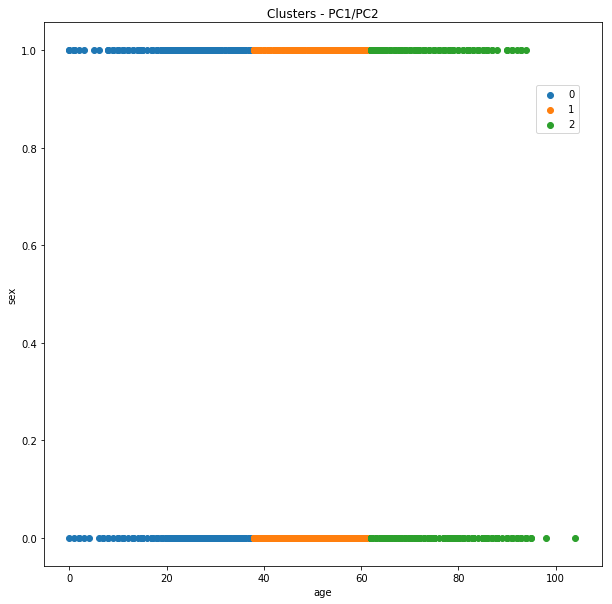

In [21]:
# Checking importance
draw_scatter(pca_df, 'age', 'sex', 'cluster', n_clusters, 'Clusters - PC1/PC2')

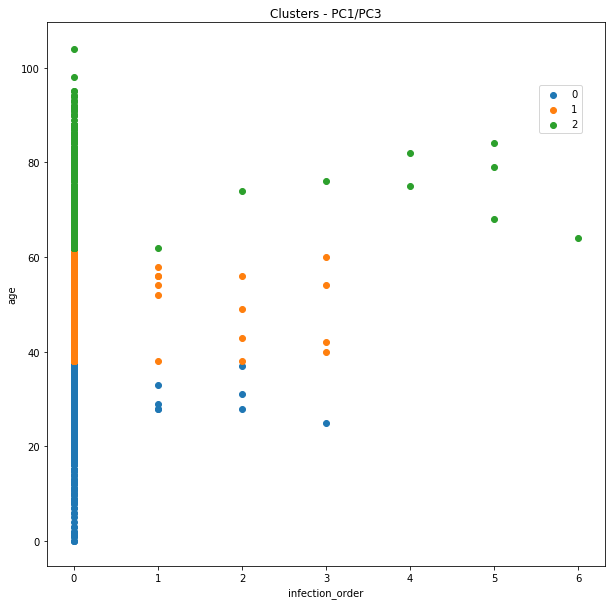

In [22]:
draw_scatter(pca_df, 'infection_order', 'age', 'cluster', n_clusters, 'Clusters - PC1/PC3')

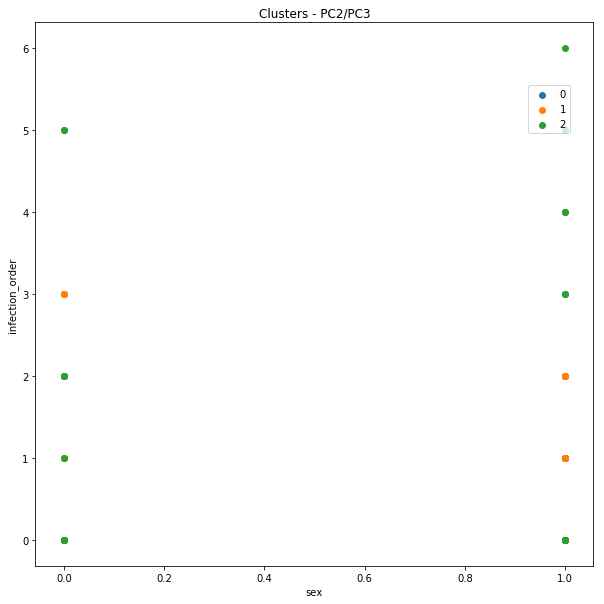

In [23]:
draw_scatter(pca_df, 'sex', 'infection_order', 'cluster', n_clusters, 'Clusters - PC2/PC3')

# Conclusions

The clusters found by K-means show that the cases are grouped by certain characteristics among the patients. 
These characteristics are focused on the variables of sex, infection order, and age.
Depending on the value of those variables the data points are distributed among the clusters.

Cluster 1 :Kids (girls & boys) with low to medium infection severity

Cluster 2 :Middle aged men & women with low to high infection severity.

Cluster 3 :Senior citizens with medium to high infection severity.